In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('train.csv')

In [53]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime 2011-11-12 16:00 object

season 1 ~ 4 봄, 여름, 가을, 겨울

holiday 0,1 휴일인지 아닌지

workingday 0, 1 일하는 날인지 아닌지

weather 1 ~ 4 숫자 커질수록 날씨 안좋음

temp 온도

atemp 체감온도

humidity 습도 0% ~ 100%

windspeed 풍속

casual 비등록고객이 대여한 자전거 수

registered 등록고객이 대여한 자전거 수

count (Target) = casual + registered

In [55]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

train.csv와 test.csv는 날짜가 다르다.

train은 1 ~ 19일까지

test는 20 ~ 말일까지

그래서 datetime에서 날짜는 제외하고 year month hour 생성

In [56]:
df = df.drop(columns=['datetime'])

<Axes: xlabel='year', ylabel='count'>

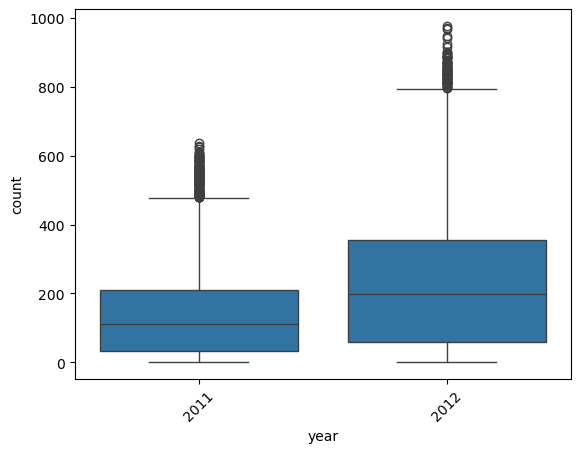

In [57]:
plt.xticks(rotation=45)
sns.boxplot(x='year', y='count', data = df)

<Axes: xlabel='month', ylabel='count'>

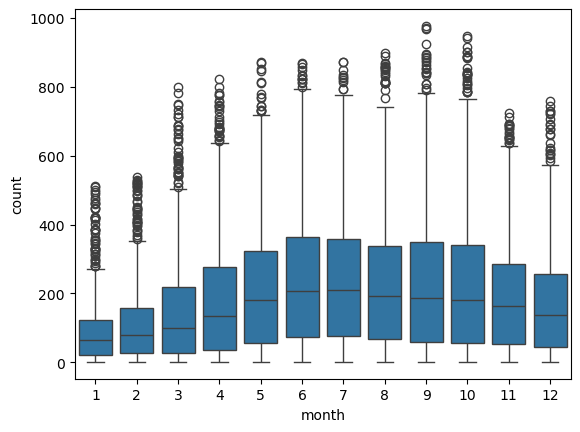

In [58]:
sns.boxplot(x='month', y='count', data = df)

<Axes: xlabel='hour', ylabel='count'>

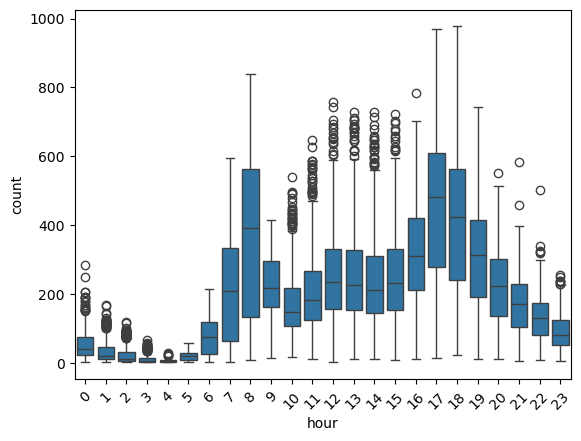

In [59]:
plt.xticks(rotation=45)
sns.boxplot(x='hour', y='count', data = df)

year month hour를 보면

year 2011보다 2012의 값이 전체적으로 큰 경향

month 겨울에 조금 낮은 경향

hour 시간별로 차이가 많이 난다

<Axes: xlabel='season', ylabel='count'>

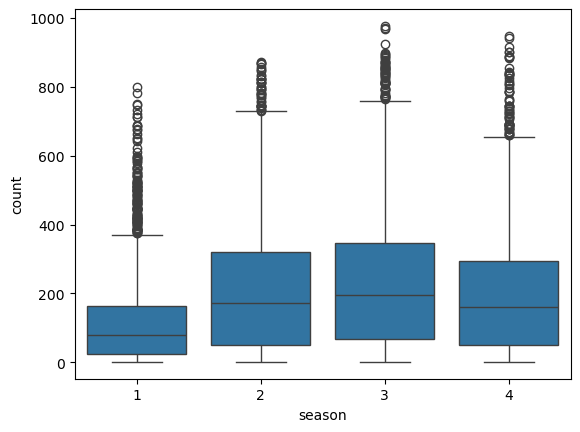

In [60]:
sns.boxplot(x='season', y='count', data=df)

<Axes: xlabel='season', ylabel='count'>

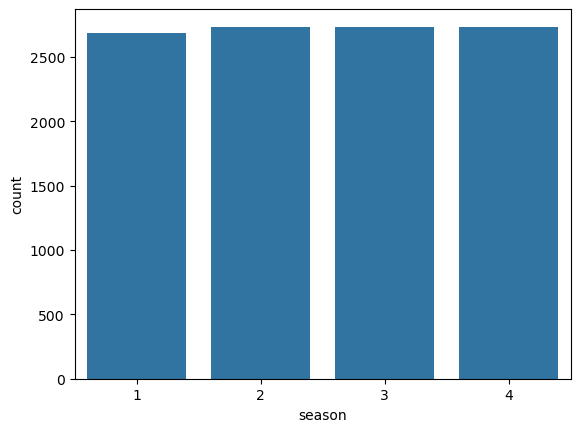

In [61]:
sns.countplot(x='season', data=df)

<Axes: xlabel='holiday', ylabel='count'>

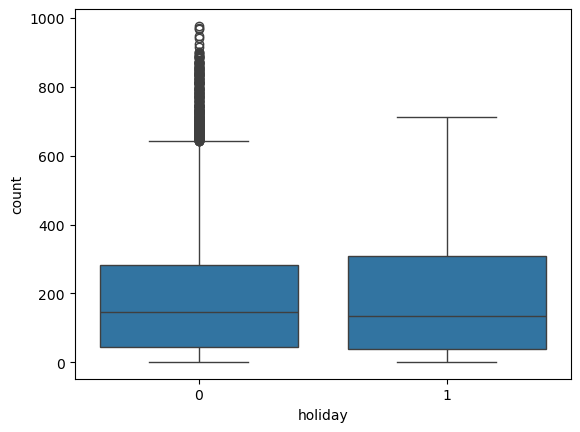

In [62]:
sns.boxplot(x='holiday', y='count', data=df)

<Axes: xlabel='workingday', ylabel='count'>

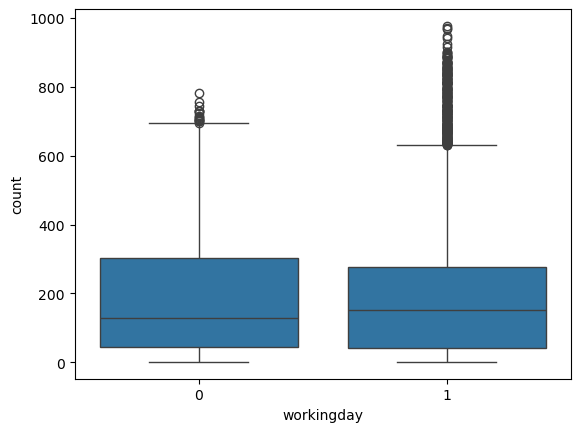

In [63]:
sns.boxplot(x='workingday', y='count', data=df)

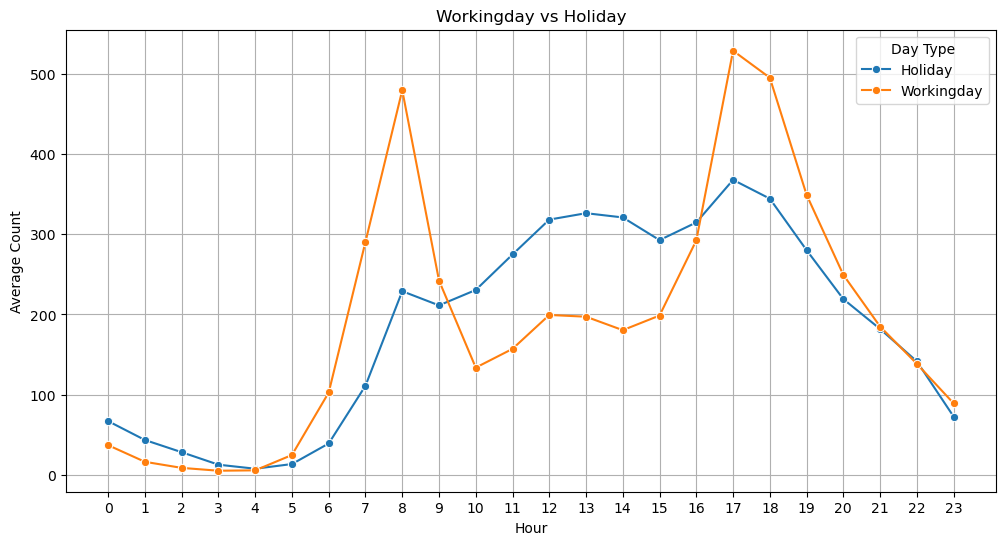

In [64]:
holiday_group = df[df['holiday'] == 1].groupby('hour')['count'].mean().reset_index()
holiday_group['type'] = 'Holiday'

workingday_group = df[df['workingday'] == 1].groupby('hour')['count'].mean().reset_index()
workingday_group['type'] = 'Workingday'


compare_df = pd.concat([holiday_group, workingday_group])
plt.figure(figsize=(12, 6))
sns.lineplot(data=compare_df, x='hour', y='count', hue='type', marker='o')
plt.title('Workingday vs Holiday')
plt.xlabel('Hour')
plt.ylabel('Average Count')
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(title='Day Type')
plt.show()

season 3 2 4 1 순서

workingday, holiday 크게 차이가 나지 않는것 같아서 같이 비교, 출근 퇴근 시간 많이 차이난다

workingday이면서 holiday일수 있는지 확인

In [65]:
wandh00 = df[(df['workingday'] == 0) & (df['holiday'] == 0)]
wandh01 = df[(df['workingday'] == 0) & (df['holiday'] == 1)]
wandh10 = df[(df['workingday'] == 1) & (df['holiday'] == 0)]
wandh11 = df[(df['workingday'] == 1) & (df['holiday'] == 1)]

print('\n\n W 0, H 0',wandh00)
print('\n\n W 0, H 1',wandh01)
print('\n\n W 1, H 0',wandh10)
print('\n\n W 1, H 1',wandh11) # 0



 W 0, H 0        season  holiday  workingday  weather   temp   atemp  humidity  \
0           1        0           0        1   9.84  14.395        81   
1           1        0           0        1   9.02  13.635        80   
2           1        0           0        1   9.02  13.635        80   
3           1        0           0        1   9.84  14.395        75   
4           1        0           0        1   9.84  14.395        75   
...       ...      ...         ...      ...    ...     ...       ...   
10809       4        0           0        1  14.76  17.425        93   
10810       4        0           0        2  15.58  19.695        82   
10811       4        0           0        2  14.76  18.940        93   
10812       4        0           0        2  16.40  20.455        82   
10813       4        0           0        2  14.76  17.425        93   

       windspeed  casual  registered  count  year  month  hour  
0         0.0000       3          13     16  2011      1  

비교 결과

W 0, H 0: 3163개의 데이터, 쉬는날 아닌데 일하지 않는다, 연차

W 0, H 1: 311 데이터, 진짜 휴일

W 1, H 0 : 7412 데이터, 일하는날

W 1, H 1 : 데이터 없음, 초과근무

In [66]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,20
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,21
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,22


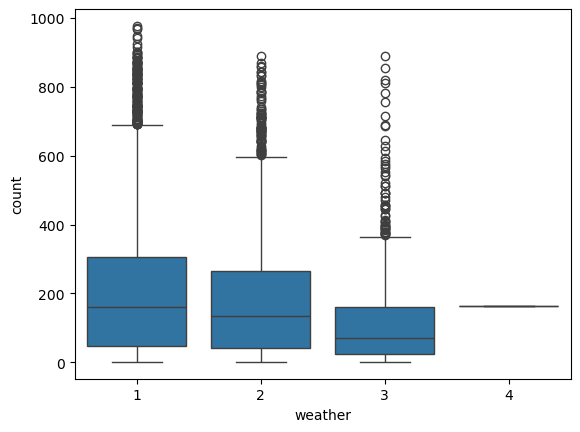

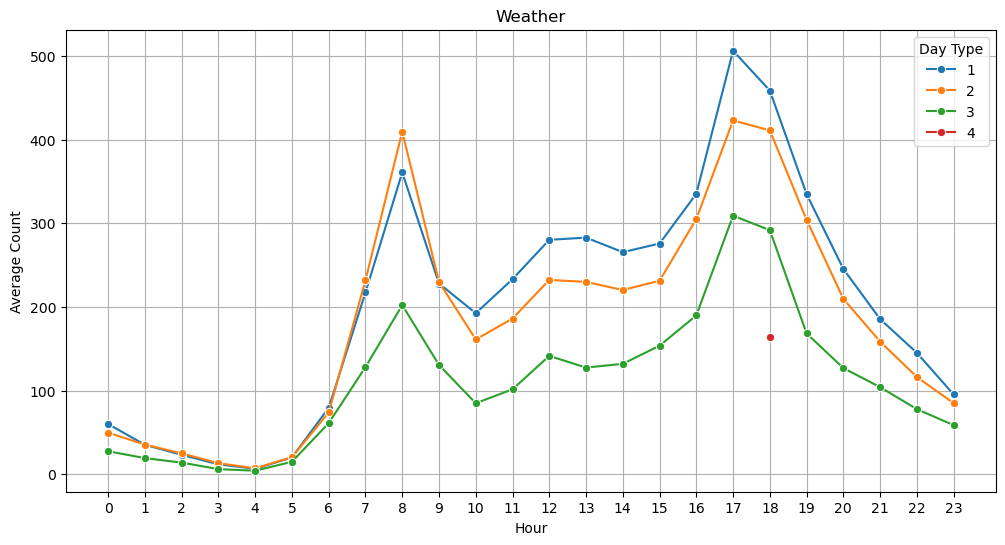

In [67]:
sns.boxplot(x='weather', y='count', data=df)

weather_group1 = df[df['weather'] == 1].groupby('hour')['count'].mean().reset_index()
weather_group1['type'] = '1'

weather_group2 = df[df['weather'] == 2].groupby('hour')['count'].mean().reset_index()
weather_group2['type'] = '2'

weather_group3 = df[df['weather'] == 3].groupby('hour')['count'].mean().reset_index()
weather_group3['type'] = '3'

weather_group4 = df[df['weather'] == 4].groupby('hour')['count'].mean().reset_index()
weather_group4['type'] = '4'

compare_df = pd.concat([weather_group1, weather_group2, weather_group3, weather_group4])
plt.figure(figsize=(12, 6))
sns.lineplot(data=compare_df, x='hour', y='count', hue='type', marker='o')
plt.title('Weather')
plt.xlabel('Hour')
plt.ylabel('Average Count')
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(title='Day Type')
plt.show()

In [68]:
print(df[df['weather'] == 4])

      season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
5631       1        0           1        4   8.2  11.365        86     6.0032   

      casual  registered  count  year  month  hour  
5631       6         158    164  2012      1    18  


weather 숫자가 커질수록, 날씨가 안좋아질수록 count 줄어드는데 4는 이상해서

1 ~ 4 별로 시간에 맞춰 시각화

숫자가 커질수록 count가 줄어드는 경향 확인, 4인 데이터는 1건 

Text(0.5, 1.0, 'Count by Temp')

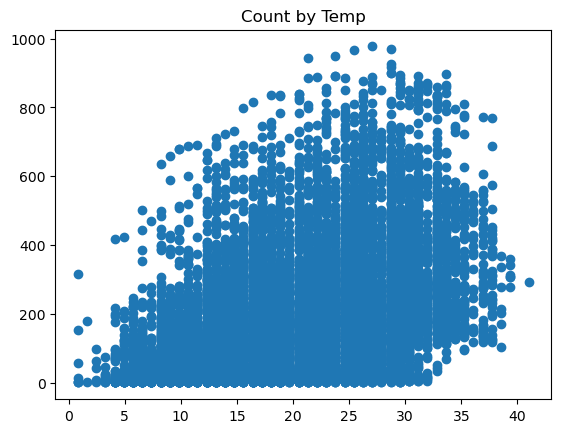

In [69]:
plt.scatter(x='temp', y='count', data=df)
plt.title('Count by Temp')

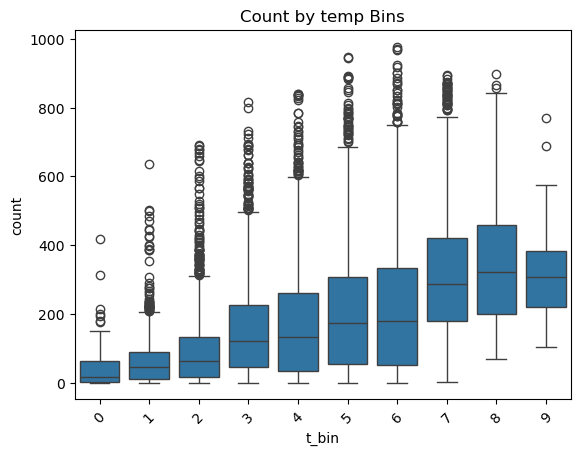

In [70]:
temp_bins = pd.cut(df['temp'], bins=10, retbins=True)[1]
df['t_bin'] = pd.cut(df['temp'], bins=temp_bins, labels=False, include_lowest=True)

sns.boxplot(x='t_bin', y='count', data=df)
plt.xticks(rotation=45)
plt.title('Count by temp Bins')
plt.show()

Text(0.5, 1.0, 'Count by atemp Bins')

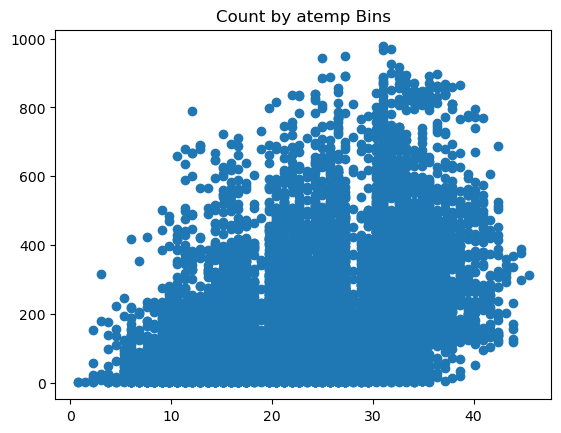

In [71]:
plt.scatter(x='atemp', y='count', data=df)
plt.title('Count by atemp Bins')

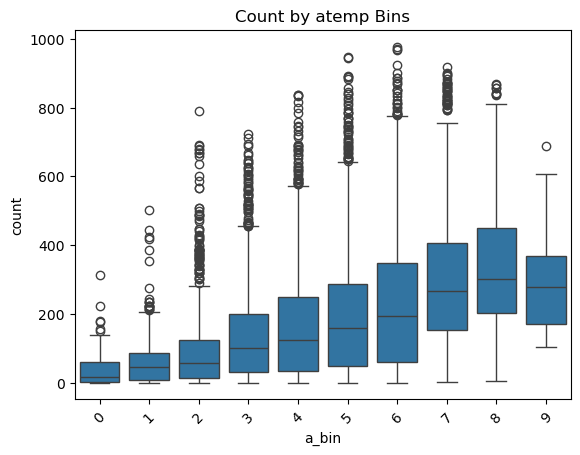

In [72]:
df['a_bin'] = pd.cut(df['atemp'], bins=10, labels=False)

sns.boxplot(x='a_bin', y='count', data=df)
plt.xticks(rotation=45)
plt.title('Count by atemp Bins')
plt.show()

In [73]:
correlation = df['temp'].corr(df['atemp'])
print(correlation)

0.9849481104817072


In [74]:
df = df.drop(columns=['atemp', 'a_bin'])

In [75]:
df

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,hour,t_bin
0,1,0,0,1,9.84,81,0.0000,3,13,16,2011,1,0,2
1,1,0,0,1,9.02,80,0.0000,8,32,40,2011,1,1,2
2,1,0,0,1,9.02,80,0.0000,5,27,32,2011,1,2,2
3,1,0,0,1,9.84,75,0.0000,3,10,13,2011,1,3,2
4,1,0,0,1,9.84,75,0.0000,0,1,1,2011,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,50,26.0027,7,329,336,2012,12,19,3
10882,4,0,1,1,14.76,57,15.0013,10,231,241,2012,12,20,3
10883,4,0,1,1,13.94,61,15.0013,4,164,168,2012,12,21,3
10884,4,0,1,1,13.94,61,6.0032,12,117,129,2012,12,22,3


temp와 atmep 상관계수 확인 0.9849, atemp drop

Text(0.5, 1.0, 'Count by Humidity')

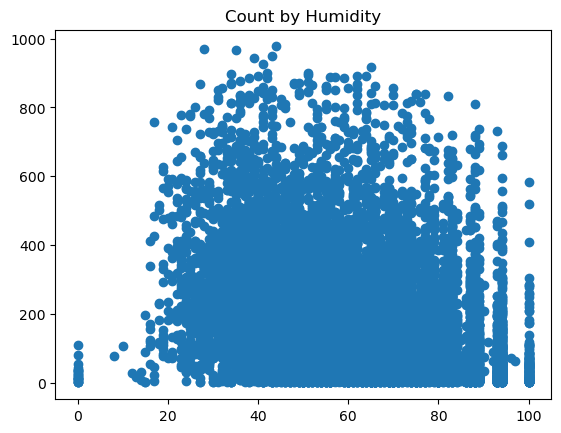

In [76]:
plt.scatter(x='humidity', y='count', data=df)
plt.title('Count by Humidity')

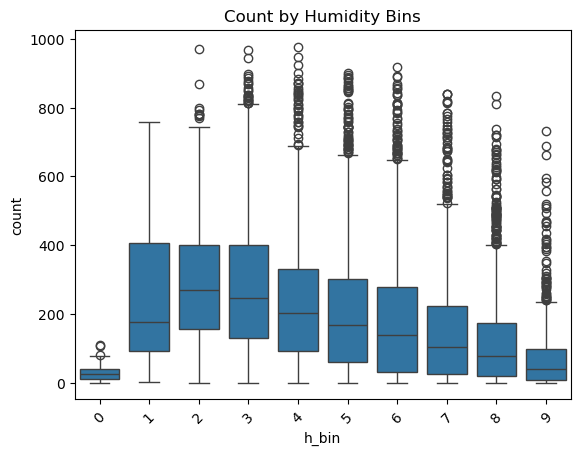

In [77]:
h_bins = pd.cut(df['humidity'], bins=10, retbins=True)[1]
df['h_bin'] = pd.cut(df['humidity'], bins=h_bins, labels=False, include_lowest=True)


sns.boxplot(x='h_bin', y='count', data=df)
plt.xticks(rotation=45)
plt.title('Count by Humidity Bins')
plt.show()

In [78]:
h_bins

array([ -0.1,  10. ,  20. ,  30. ,  40. ,  50. ,  60. ,  70. ,  80. ,
        90. , 100. ])

Text(0.5, 1.0, 'Count by windspeed')

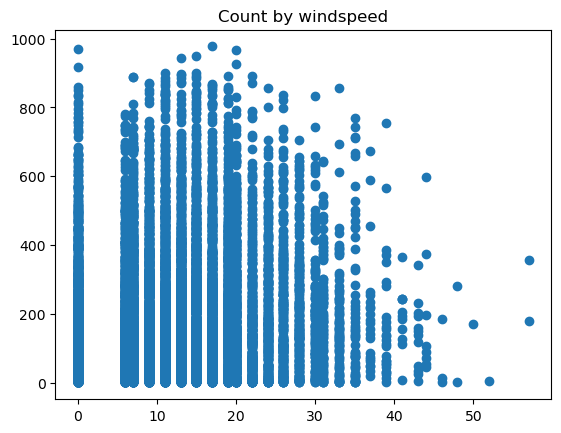

In [79]:
plt.scatter(x='windspeed', y='count', data=df)
plt.title('Count by windspeed')

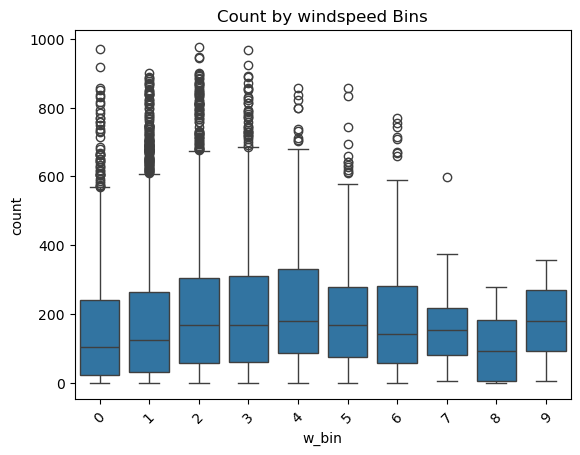

In [80]:
w_bins = pd.cut(df['windspeed'], bins=10, retbins=True)[1]
df['w_bin'] = pd.cut(df['windspeed'], bins=w_bins, labels=False, include_lowest=True)

sns.boxplot(x='w_bin', y='count', data=df)
plt.xticks(rotation=45)
plt.title('Count by windspeed Bins')
plt.show()

In [81]:
df = df.drop(columns=['casual','registered'])
df

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,hour,t_bin,h_bin,w_bin
0,1,0,0,1,9.84,81,0.0000,16,2011,1,0,2,8,0
1,1,0,0,1,9.02,80,0.0000,40,2011,1,1,2,7,0
2,1,0,0,1,9.02,80,0.0000,32,2011,1,2,2,7,0
3,1,0,0,1,9.84,75,0.0000,13,2011,1,3,2,7,0
4,1,0,0,1,9.84,75,0.0000,1,2011,1,4,2,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,50,26.0027,336,2012,12,19,3,4,4
10882,4,0,1,1,14.76,57,15.0013,241,2012,12,20,3,5,2
10883,4,0,1,1,13.94,61,15.0013,168,2012,12,21,3,6,2
10884,4,0,1,1,13.94,61,6.0032,129,2012,12,22,3,6,1


train 데이터 로드

datetime 형변환, year month hour 생성

datetime drop

temp와  atemp의 상관계수 확인 0.9849 너무 비슷 그냥 atemp삭제

temp에서 t_bin열 생성

humidity에서 h_bin열 생성

windspeed에서 w_bin열 생성

casual registered 열 drop

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여
# RMSLE(Root Mean Squared Logarithmic Error) 계산,
# 예측값과 실제값의 로그를 취한 후 제곱한 값의 평균을 계산하고 제곱근을 취하여 구함
# 로그 함수를 사용하여 비율을 계산하므로 상대적인 크기 차이가 작은 예측 오류에 민감하게 반응.
# 큰 오류를 상대적으로 덜 강조. 양수 값이 크게 다르고 정확한 예측보다는 상대적인 예측이 중요한 경우 적용
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [83]:
from sklearn.linear_model import LinearRegression

y_target = df['count']
X_features = df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.163, RMSE: 141.207, MAE: 106.151


In [84]:
X_features

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,hour,t_bin,h_bin,w_bin
0,1,0,0,1,9.84,81,0.0000,2011,1,0,2,8,0
1,1,0,0,1,9.02,80,0.0000,2011,1,1,2,7,0
2,1,0,0,1,9.02,80,0.0000,2011,1,2,2,7,0
3,1,0,0,1,9.84,75,0.0000,2011,1,3,2,7,0
4,1,0,0,1,9.84,75,0.0000,2011,1,4,2,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,50,26.0027,2012,12,19,3,4,4
10882,4,0,1,1,14.76,57,15.0013,2012,12,20,3,5,2
10883,4,0,1,1,13.94,61,15.0013,2012,12,21,3,6,2
10884,4,0,1,1,13.94,61,6.0032,2012,12,22,3,6,1


In [85]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            321.0  569.0
3151         798            235.0  563.0
412          745            187.0  558.0
966          884            326.0  558.0
1003         713            164.0  549.0


<Axes: >

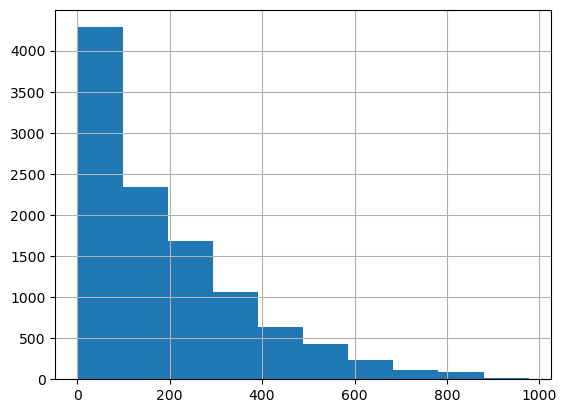

In [86]:
y_target.hist()

<Axes: >

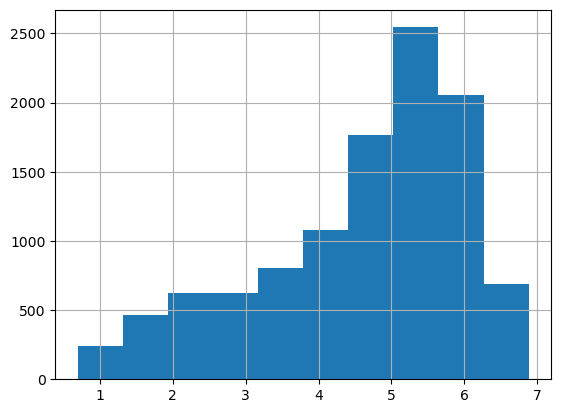

In [87]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [88]:
y_log_transform = np.log1p(y_target)
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.019, RMSE: 163.646, MAE: 110.036


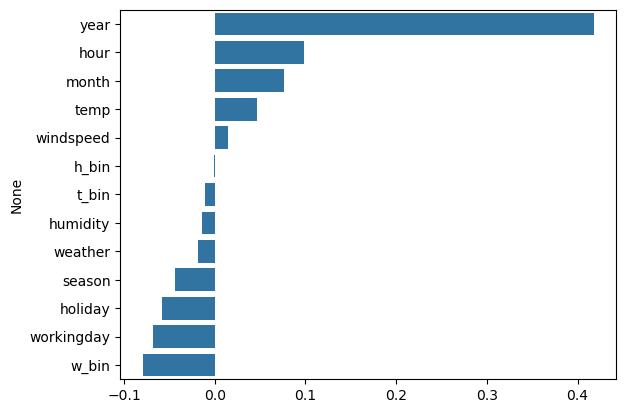

In [89]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

In [90]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'hour', 'holiday',
                                              'workingday','season','weather','t_bin','h_bin','w_bin'])

X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 79
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.324, RMSE: 47.220, MAE: 29.068


In [91]:
X_features_ohe

,temp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,...,w_bin_0,w_bin_1,w_bin_2,w_bin_3,w_bin_4,w_bin_5,w_bin_6,w_bin_7,w_bin_8,w_bin_9
0,9.84,81,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,9.02,80,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,9.02,80,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,9.84,75,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,9.84,75,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,50,26.0027,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
10882,14.76,57,15.0013,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
10883,13.94,61,15.0013,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
10884,13.94,61,6.0032,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


하이퍼파라미터 튜닝


params = {

    'n_estimators': [300, 500, 700],
    
    'learning_rate': [0.01, 0.05, 0.1],
    
    'max_depth': [4, 6, 8],
    
    'num_leaves': [20, 40, 60],
    
    'min_child_samples': [10, 20, 30]

}

lgbm = LGBMRegressor()

grid_cv = GridSearchCV(lgbm, param_grid=params, scoring='neg_mean_squared_log_error', cv=3, verbose=1, n_jobs=-1)

grid_cv.fit(X_train, y_train)

최적 하이퍼파라미터

print("최적 하이퍼파라미터:", grid_cv.best_params_)

최적 모델로 예측

best_lgbm = grid_cv.best_estimator_

preds = best_lgbm.predict(X_test)

preds_exp = np.expm1(preds)

y_test_exp = np.expm1(y_test)

evaluate_regr(y_test_exp, preds_exp)
결과 아래와 같이 나옴

In [92]:
best_lgbm = LGBMRegressor(
    learning_rate=0.1,
    max_depth=6,
    min_child_samples=30,
    n_estimators=500,
    num_leaves=20
)

In [93]:
best_lgbm.fit(X_features_ohe, y_target_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 10886, number of used features: 79
[LightGBM] [Info] Start training from score 4.591364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(max_depth=6, min_child_samples=30, n_estimators=500,
              num_leaves=20)

Test 파일 로드

In [94]:
df = pd.read_csv('test.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['t_bin'] = pd.cut(df['temp'], bins=temp_bins, labels=False, include_lowest=True)
df['h_bin'] = pd.cut(df['humidity'], bins=h_bins, labels=False, include_lowest=True)
df['w_bin'] = pd.cut(df['windspeed'], bins=w_bins, labels=False, include_lowest=True)

In [95]:
df['h_bin'].value_counts().sort_index()

h_bin
1      17
2     265
3     559
4     933
5    1004
6    1095
7     954
8    1180
9     486
Name: count, dtype: int64

In [96]:
X_t_features = df.drop(columns=['datetime', 'atemp'])
X_t_features_ohe = pd.get_dummies(X_t_features, columns=['year', 'month', 'hour', 'holiday',
                                              'workingday','season','weather','t_bin','h_bin','w_bin'])

In [97]:
X_t_features_ohe.columns[63:72]

Index(['h_bin_1', 'h_bin_2', 'h_bin_3', 'h_bin_4', 'h_bin_5', 'h_bin_6',
       'h_bin_7', 'h_bin_8', 'h_bin_9'],
      dtype='object')

In [98]:
X_t_features_ohe[X_t_features_ohe.columns[63:72]]

,h_bin_1,h_bin_2,h_bin_3,h_bin_4,h_bin_5,h_bin_6,h_bin_7,h_bin_8,h_bin_9
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False
2,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
6488,False,False,False,False,True,False,False,False,False
6489,False,False,False,False,True,False,False,False,False
6490,False,False,False,False,True,False,False,False,False
6491,False,False,False,False,True,False,False,False,False


In [99]:
missing_cols = set(X_features_ohe.columns) - set(X_t_features_ohe.columns)
print(missing_cols)

{'h_bin_0'}


In [100]:
missing_cols = set(X_features_ohe.columns) - set(X_t_features_ohe.columns)
for col in missing_cols:
    X_t_features_ohe[col] = False
X_t_features_ohe = X_t_features_ohe[X_features_ohe.columns]

In [101]:
X_t_features_ohe[X_t_features_ohe.columns[63:73]]

,h_bin_0,h_bin_1,h_bin_2,h_bin_3,h_bin_4,h_bin_5,h_bin_6,h_bin_7,h_bin_8,h_bin_9
0,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
6488,False,False,False,False,False,True,False,False,False,False
6489,False,False,False,False,False,True,False,False,False,False
6490,False,False,False,False,False,True,False,False,False,False
6491,False,False,False,False,False,True,False,False,False,False


train파일과 test파일에서 똑같이 datetime 형변환, 파생변수 t_bin, h_bin, w_bin 생성 후

원핫 인코딩 시행

시행후 X_features_ohe와 X_t_features_ohe의 차이나는 부분이 있는지 확인

test파일에는 h_bin_0 0~10%d의 값이 없음, 인위적으로 h_bin_0 추가, False 삽입

In [102]:
preds = best_lgbm.predict(X_t_features_ohe)
preds = np.expm1(preds)
preds = np.maximum(preds, 0)

submission = pd.DataFrame({'datetime': df['datetime'], 'count': preds})
submission.to_csv('submission.csv', index=False)

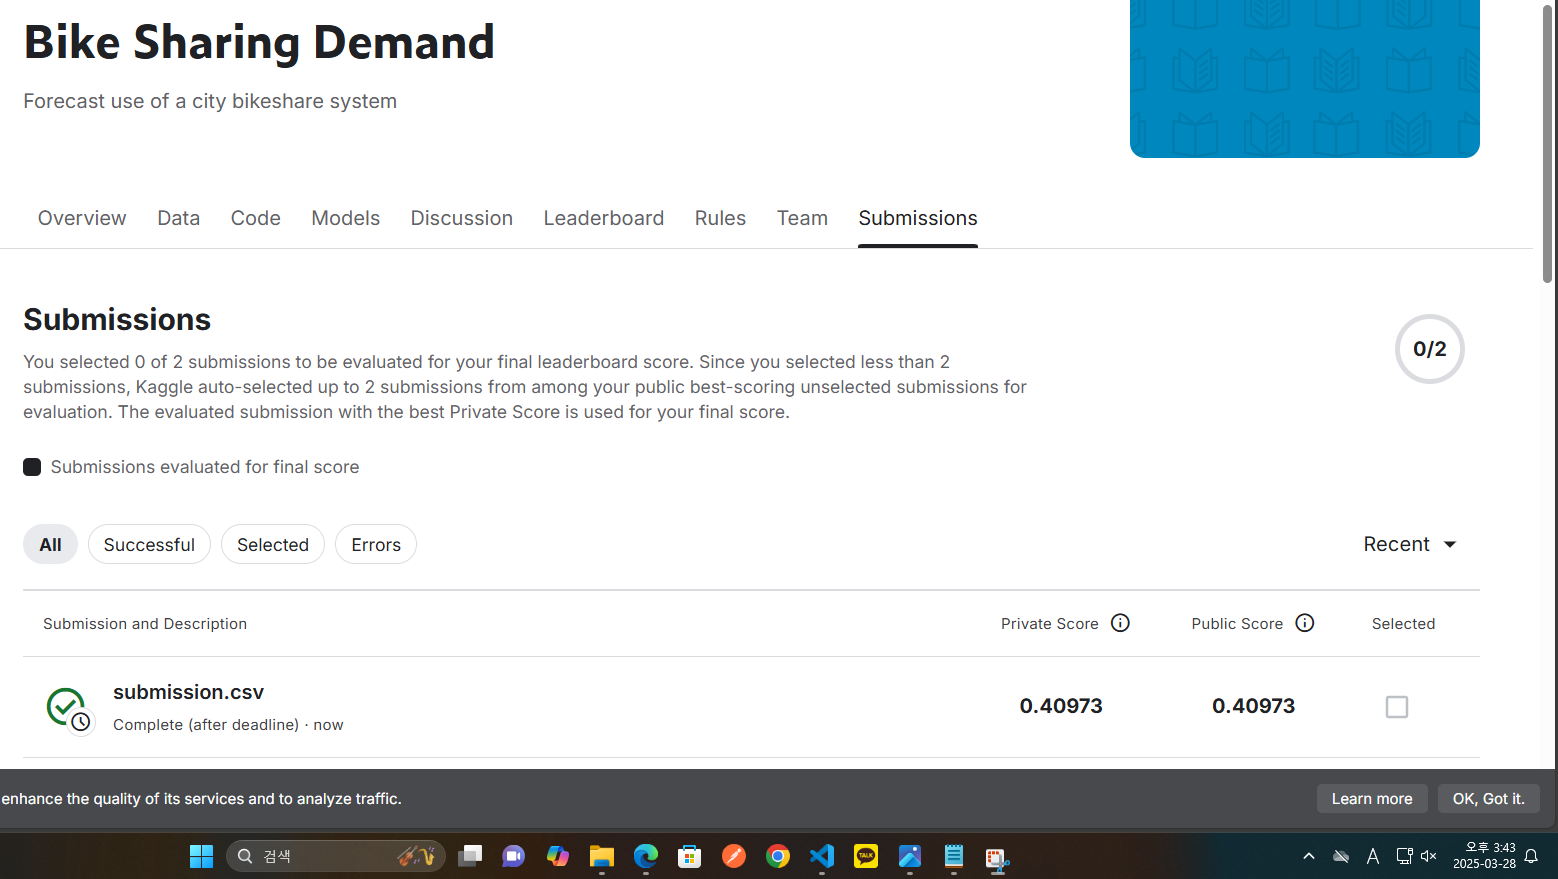

In [103]:
from IPython.display import Image, display

img = r'C:\LJH\0327_Bicycle\0328final.png'

display(Image(filename=img))